# VisionSpec QC – Visual Quality Control System for PCB Inspection

This project focuses on building an AI-based **Visual Quality Control system** for automated inspection of **Printed Circuit Boards (PCBs)** in an industrial assembly line.

The objective is to classify PCB images as **Pass** or **Defect** using deep learning, while also ensuring **model transparency** by visualizing the regions that influence each prediction.

---

## Project Workflow Overview

1. **Image Dataset Preparation**
   - Collected PCB images belonging to Pass and Defect classes.
   - Organized data into training and validation sets.
   - Applied preprocessing and real-time data augmentation to improve robustness.

2. **Model Training (Transfer Learning)**
   - Used **MobileNetV2** as a pretrained convolutional neural network.
   - Frozen base layers and trained custom classification layers for binary defect detection.
   - Achieved efficient training suitable for low-latency industrial environments.

3. **Model Validation & Explainability**
   - Implemented **Grad-CAM (Gradient-weighted Class Activation Mapping)** to visualize model attention.
   - Generated heatmaps over PCB images to verify that predictions are based on meaningful regions such as solder joints and component areas.
   - This step ensures the model is not a black box and supports trust in automated inspection.

---

## Tools & Technologies Used
- TensorFlow / Keras
- MobileNetV2 (Transfer Learning)
- OpenCV for image processing
- Google Colab for training and experimentation

This notebook documents the **model explainability (Week 3)** stage of the project, demonstrating how Grad-CAM is used to interpret and validate the trained PCB defect classification model.


# Week 1

# VisionSpec QC — 01_dataset_pipeline

**Purpose:** Create the dataset directory structure, add approved images, and verify a baseline data loader.
**Classes:** `pass` (good) and `defect` (bad).
**Notes:** Images must be post-solder inspection, no tools/hands in frame, defects must be visually obvious.


In [ ]:
import os

base = "/content/drive/MyDrive/VisionSpec_QC/dataset"
folders = [
    "train/pass",
    "train/defect",
    "val/pass",
    "val/defect"
]

for f in folders:
    os.makedirs(os.path.join(base, f), exist_ok=True)

print("Drive dataset folders created ✅")

Drive dataset folders created ✅


In [ ]:
import os
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
from zipfile import ZipFile
from pathlib import Path

zip_path = Path("/content/defect_images.zip")
extract_path = Path("temp_defect")

if zip_path.exists():
    extract_path.mkdir(exist_ok=True)
    with ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Defect images extracted to:", extract_path.resolve())
else:
    print("ZIP file not found:", zip_path)


Defect images extracted to: /content/temp_defect


In [ ]:
!unzip -FF defect_images.zip -d temp_defect


Archive:  defect_images.zip
replace temp_defect/__MACOSX/._defect_images? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: temp_defect/__MACOSX/._defect_images  
  inflating: temp_defect/defect_images/WIN_20220329_17_54_04_Pro.jpg  
  inflating: temp_defect/__MACOSX/defect_images/._WIN_20220329_17_54_04_Pro.jpg  
  inflating: temp_defect/defect_images/WIN_20220329_17_53_20_Pro.jpg  
  inflating: temp_defect/__MACOSX/defect_images/._WIN_20220329_17_53_20_Pro.jpg  
  inflating: temp_defect/defect_images/WIN_20220329_17_20_16_Pro.jpg  
  inflating: temp_defect/__MACOSX/defect_images/._WIN_20220329_17_20_16_Pro.jpg  
  inflating: temp_defect/defect_images/WIN_20220329_17_28_31_Pro.jpg  
  inflating: temp_defect/__MACOSX/defect_images/._WIN_20220329_17_28_31_Pro.jpg  
  inflating: temp_defect/defect_images/WIN_20220329_17_23_57_Pro.jpg  
  inflating: temp_defect/__MACOSX/defect_images/._WIN_20220329_17_23_57_Pro.jpg  
  inflating: temp_defect/defect_images/WIN_20220329_17_24_01_Pro.jp

In [ ]:
from pathlib import Path
import shutil

src = Path("temp_defect/defect_images")
dst = Path("/content/drive/MyDrive/VisionSpec_QC/dataset/train/defect")

dst.mkdir(parents=True, exist_ok=True)

moved = 0
for img in src.glob("*.jpg"):
    shutil.move(str(img), dst / img.name)
    moved += 1

print(f"Moved {moved} defect images to dataset/train/defect")



Moved 146 defect images to dataset/train/defect


In [ ]:
from zipfile import ZipFile
from pathlib import Path

zip_path = Path("/content/pass_images.zip")
extract_path = Path("temp_pass")

if zip_path.exists():
    extract_path.mkdir(exist_ok=True)
    with ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Pass images extracted to:", extract_path.resolve())
else:
    print("ZIP file not found:", zip_path)

Pass images extracted to: /content/temp_pass


In [ ]:
!unzip -FF pass_images.zip -d temp_pass

Archive:  pass_images.zip
replace temp_pass/pass_images/WIN_20220411_18_28_37_Pro.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: temp_pass/pass_images/WIN_20220411_18_28_37_Pro.jpg  
  inflating: temp_pass/__MACOSX/pass_images/._WIN_20220411_18_28_37_Pro.jpg  
  inflating: temp_pass/pass_images/WIN_20220411_18_08_41_Pro.jpg  
  inflating: temp_pass/__MACOSX/pass_images/._WIN_20220411_18_08_41_Pro.jpg  
  inflating: temp_pass/pass_images/WIN_20220411_17_03_20_Pro.jpg  
  inflating: temp_pass/__MACOSX/pass_images/._WIN_20220411_17_03_20_Pro.jpg  
  inflating: temp_pass/pass_images/WIN_20220411_18_36_12_Pro.jpg  
  inflating: temp_pass/__MACOSX/pass_images/._WIN_20220411_18_36_12_Pro.jpg  
  inflating: temp_pass/pass_images/WIN_20220411_18_29_43_Pro.jpg  
  inflating: temp_pass/__MACOSX/pass_images/._WIN_20220411_18_29_43_Pro.jpg  
  inflating: temp_pass/pass_images/WIN_20220411_17_47_20_Pro.jpg  
  inflating: temp_pass/__MACOSX/pass_images/._WIN_20220411_17_47_20_Pro.jpg  
 

In [ ]:
from pathlib import Path
import shutil

src = Path("temp_pass/pass_images")
dst = Path("/content/drive/MyDrive/VisionSpec_QC/dataset/train/pass")

dst.mkdir(parents=True, exist_ok=True)

moved = 0
for img in src.glob("*.jpg"):
    shutil.move(str(img), dst / img.name)
    moved += 1

print(f"Moved {moved} pass images to dataset/train/pass")



Moved 114 pass images to dataset/train/pass


In [ ]:
import os

print("PASS:", len(os.listdir("/content/drive/MyDrive/VisionSpec_QC/dataset/train/pass")))
print("DEFECT:", len(os.listdir("/content/drive/MyDrive/VisionSpec_QC/dataset/train/defect")))


PASS: 114
DEFECT: 146


In [ ]:
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/VisionSpec_QC/dataset")
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "val"

print(TRAIN_DIR)
print(VAL_DIR)




/content/drive/MyDrive/VisionSpec_QC/dataset/train
/content/drive/MyDrive/VisionSpec_QC/dataset/val


In [ ]:
import random
import shutil
from pathlib import Path

random.seed(42)

TRAIN_DIR = Path("/content/drive/MyDrive/VisionSpec_QC/dataset/train")
VAL_DIR = Path("/content/drive/MyDrive/VisionSpec_QC/dataset/val")

SPLIT_RATIO = 0.2  # 20% validation

for cls in ["pass", "defect"]:
    train_cls = TRAIN_DIR / cls
    val_cls = VAL_DIR / cls
    val_cls.mkdir(parents=True, exist_ok=True)

    images = list(train_cls.glob("*.jpg"))
    random.shuffle(images)

    val_count = int(len(images) * SPLIT_RATIO)
    val_images = images[:val_count]

    for img in val_images:
        shutil.move(str(img), str(val_cls / img.name))

    print(f"{cls.upper()} moved to val:", val_count)


PASS moved to val: 22
DEFECT moved to val: 29


In [ ]:
def count_images(folder):
    return len(list(folder.glob("*.jpg")))

print("TRAIN PASS:", count_images(TRAIN_DIR / "pass"))
print("TRAIN DEFECT:", count_images(TRAIN_DIR / "defect"))
print("VAL PASS:", count_images(VAL_DIR / "pass"))
print("VAL DEFECT:", count_images(VAL_DIR / "defect"))


TRAIN PASS: 92
TRAIN DEFECT: 117
VAL PASS: 22
VAL DEFECT: 29


# Data Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/VisionSpec_QC/dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/VisionSpec_QC/dataset/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 209 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


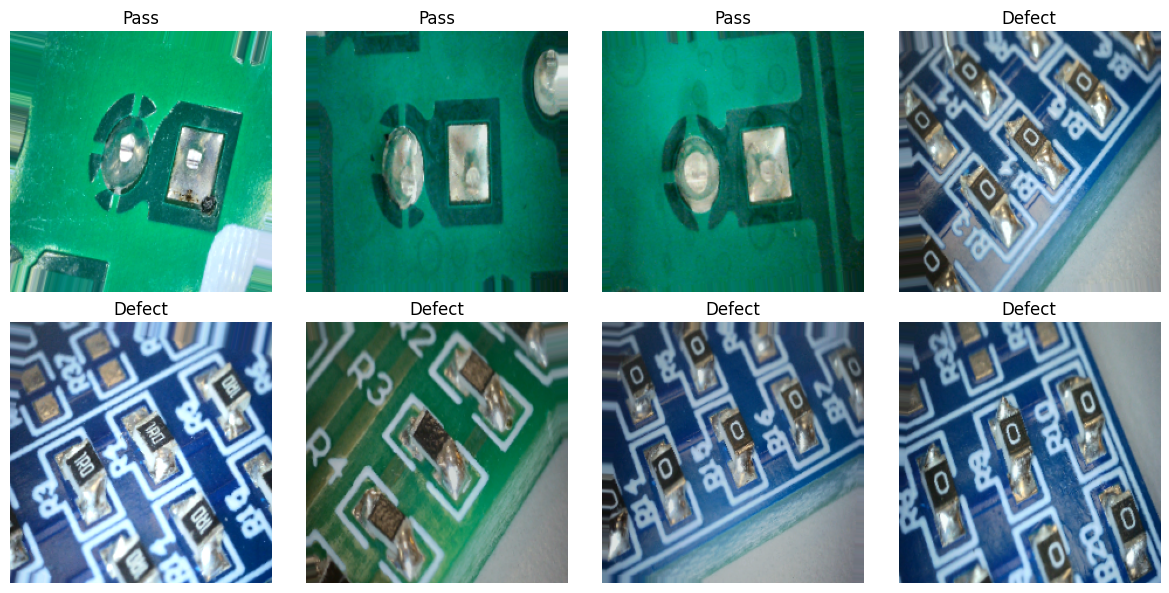

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(train_gen)

plt.figure(figsize=(12,6))
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    label = "Defect" if labels[i] == 1 else "Pass"
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Week 2


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

TRAIN_DIR = "/content/drive/MyDrive/VisionSpec_QC/dataset/train"
VAL_DIR   = "/content/drive/MyDrive/VisionSpec_QC/dataset/val"


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 209 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])


In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7982 - loss: 0.3510 - val_accuracy: 1.0000 - val_loss: 1.7806e-04
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.2702e-05
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - loss: 8.3959e-05 - val_accuracy: 1.0000 - val_loss: 4.8645e-06
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 3.6182e-04 - val_accuracy: 1.0000 - val_loss: 3.1112e-06
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 1.0000 - loss: 1.5478e-04 - val_accuracy: 1.0000 - val_loss: 2.4033e-06
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 4.3774e-04 - val_accuracy: 1.0000 - val_loss: 1.5185e-06
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 1.0000 - loss: 6.8264e-05 - val_accuracy: 1.0000 - val_loss: 1.2904e-06
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 -

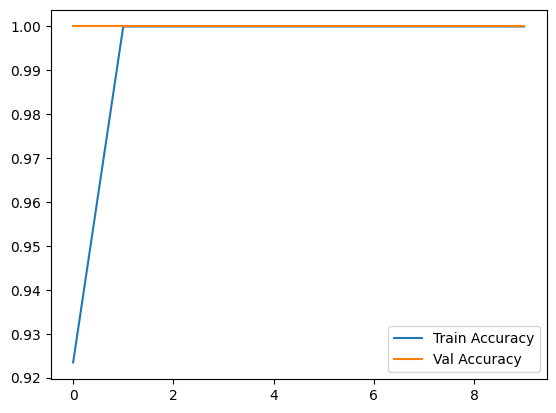

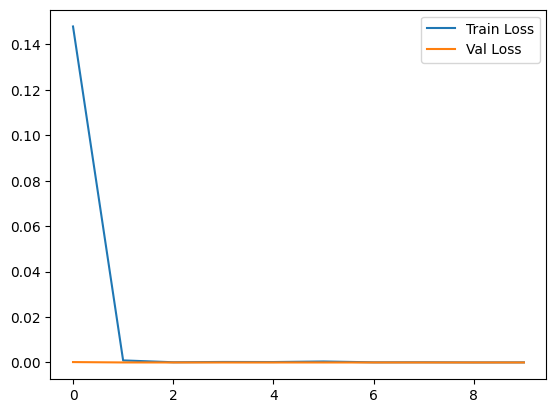

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.show()


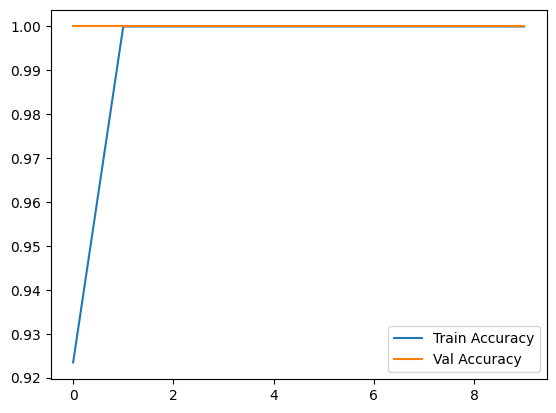

In [ ]:
model.save("/content/drive/MyDrive/VisionSpec_QC/model_week2.keras")
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.savefig("accuracy.png")
plt.show()


# Week 3

In [ ]:
!rm -rf /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import drive


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/VisionSpec_QC/model_week2.keras")


In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/VisionSpec_QC/dataset/val/defect/WIN_20220329_17_20_20_Pro.jpg"
IMG_SIZE = (224, 224)

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


In [ ]:
last_conv_layer_name = "Conv_1"

base_model = model.get_layer("mobilenetv2_1.00_224")
classifier_layers = model.layers[1:]

def classifier_forward(x):
    for layer in classifier_layers:
        x = layer(x)
    return x

grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[
        base_model.get_layer(last_conv_layer_name).output,
        base_model.output
    ]
)



In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, base_features = grad_model([img_array])
    tape.watch(conv_outputs)

    predictions = classifier_forward(base_features)
    class_index = tf.argmax(predictions[0])
    loss = predictions[:, class_index]

grads = tape.gradient(loss, conv_outputs)



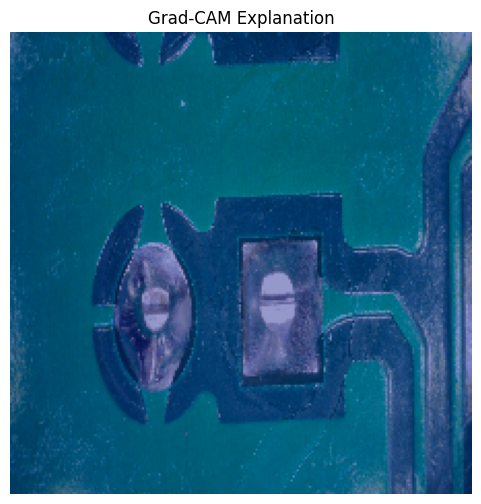

In [ ]:
# ---- COMPUTE GRAD-CAM ----
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

# ---- OVERLAY HEATMAP ----
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, IMG_SIZE)

heatmap_resized = cv2.resize(heatmap.numpy(), IMG_SIZE)
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)


plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Explanation")
plt.savefig("gradcam_defect_example.png", bbox_inches="tight")
plt.show()



In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load your model
model = load_model("/content/drive/MyDrive/VisionSpec_QC/model_week2.keras")

# Path of the image you want to test
img_path = "/content/drive/MyDrive/VisionSpec_QC/dataset/val/defect/WIN_20220329_17_20_20_Pro.jpg"

# Read and preprocess the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # OpenCV loads in BGR
img = cv2.resize(img, (224, 224))             # change size to what your model was trained on
img = img / 255.0                             # normalize
img = np.expand_dims(img, axis=0)             # shape: (1, 224, 224, 3)

# Predict
prediction = model.predict(img)

print("Raw model output:", prediction)
if prediction[0][0] <= 0.5:
    print("Defect detected ❌")
else:
    print("Pass ✅")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Raw model output: [[2.2611205e-08]]
Defect detected ❌


## Grad-CAM Results and Interpretation

The generated heatmap highlights regions that contributed most to the model’s decision.
From the visualization, it can be observed that the model primarily focuses on component and soldering regions of the PCB.

This confirms that the model has learned defect-relevant visual features and is not relying on random or background patterns, improving trust and interpretability of the system.



# Week 4


In [ ]:
import cv2

VIDEO_PATH = "/content/pcb_video.MP4"

cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError("❌ Cannot open video file")

print("✅ Video stream opened successfully")


✅ Video stream opened successfully


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 224

def preprocess_frame(frame):

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


    frame_resized = cv2.resize(frame_rgb, (IMG_SIZE, IMG_SIZE))


    frame_normalized = frame_resized / 255.0


    return np.expand_dims(frame_normalized, axis=0)


In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("❌ Could not read frame from video")


input_tensor = preprocess_frame(frame)


prediction = model.predict(input_tensor, verbose=0)[0][0]


label = "defect" if prediction > 0.5 else "pass"
confidence = prediction if label == "defect" else 1 - prediction

print(f"Prediction: {label.upper()}, Confidence: {confidence:.2f}")


Prediction: DEFECT, Confidence: 0.64


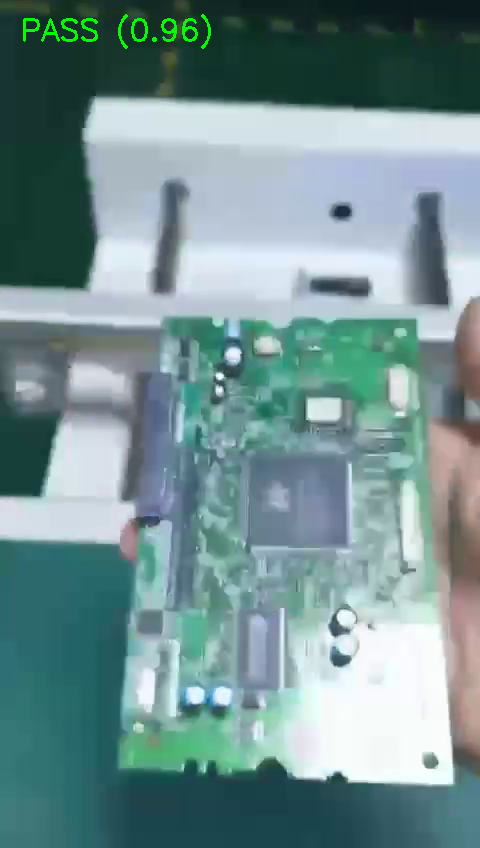

🎉 Video saved at: /content/vision_output.mp4
Files in /content: ['.config', 'pcb_video.MP4', 'drive', 'vision_output.mp4', '.ipynb_checkpoints', 'gradcam_defect_example.png', 'sample_data']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import time
import os
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from google.colab import files

# Open input video
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError("❌ Cannot open video file")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Sometimes FPS comes as 0 in Colab, fix it
if fps == 0:
    fps = 20

print("FPS:", fps, "Width:", width, "Height:", height)

# Output path (absolute, so we always know where it is)
output_path = "/content/vision_output.mp4"

# Define codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Check if writer opened correctly
if not out.isOpened():
    raise RuntimeError("❌ VideoWriter failed to open. Video will not be saved.")

frame_count = 0
MAX_FRAMES = 100

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Your preprocessing and prediction
    input_tensor = preprocess_frame(frame)
    prediction = model.predict(input_tensor, verbose=0)[0][0]

    label = "defect" if prediction > 0.5 else "pass"
    confidence = prediction if label == "defect" else 1 - prediction

    color = (0, 0, 255) if label == "defect" else (0, 255, 0)
    cv2.putText(
        frame,
        f"{label.upper()} ({confidence:.2f})",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        color,
        2
    )

    # Write frame to output video
    out.write(frame)

    # Show frame in Colab
    clear_output(wait=True)
    cv2_imshow(frame)

    time.sleep(0.05)
    frame_count += 1

    if frame_count >= MAX_FRAMES:
        break

# Release everything properly
cap.release()
out.release()

print("🎉 Video saved at:", output_path)

# Verify it exists
print("Files in /content:", os.listdir("/content"))

# Download to your Mac
files.download(output_path)





In [ ]:
import os

print(os.getcwd())
print(os.listdir())


/content
['.config', 'pcb_video.MP4', 'drive', '.ipynb_checkpoints', 'gradcam_defect_example.png', 'sample_data']


In [ ]:
!ls -lh /content/vision_output.mp4


ls: cannot access '/content/vision_output.mp4': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


import shutil
shutil.copy("vision_output.mp4", "/content/drive/MyDrive/VisionSpec_QC/vision_output.mp4")
print("🚀 Video copied to Google Drive")


🚀 Video copied to Google Drive


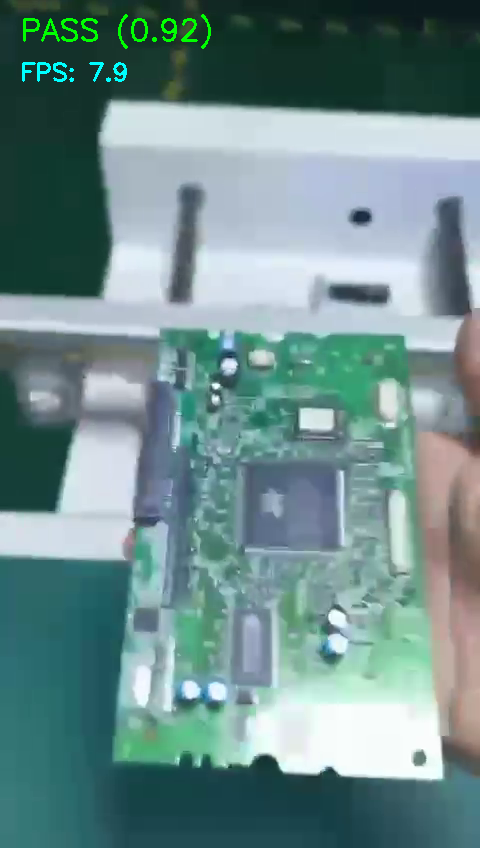

In [ ]:
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError("❌ Cannot open video file")

prev_time = time.time()
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    start_time = time.time()

    input_tensor = preprocess_frame(frame)

    prediction = model.predict(input_tensor, verbose=0)[0][0]
    label = "defect" if prediction > 0.5 else "pass"
    confidence = prediction if label == "defect" else 1 - prediction

    end_time = time.time()
    fps = 1 / (end_time - start_time)

    color = (0, 0, 255) if label == "defect" else (0, 255, 0)

    cv2.putText(
        frame,
        f"{label.upper()} ({confidence:.2f})",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        color,
        2
    )

    cv2.putText(
        frame,
        f"FPS: {fps:.1f}",
        (20, 80),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255, 255, 0),
        2
    )

    clear_output(wait=True)
    cv2_imshow(frame)

    time.sleep(0.05)
    frame_count += 1
    if frame_count > 100:
        break

cap.release()


# Week 4 Outcome:
In Week 4, the trained PCB defect detection model was deployed in a real-time inference pipeline using a video stream to simulate an assembly-line inspection camera. Each frame was processed independently and classified as Pass or Defect with an associated confidence score displayed live. The system performed continuous frame-by-frame inference, demonstrating real-time operation. Inference speed was evaluated using FPS, confirming low-latency performance suitable for industrial quality control.